# Important Functions 

For ease of use, I've made a copy of everything essential for running in it's own section since it was getting messy. 

To Talk about: 
* Normalizing having an interfering effect with the data
* PIL Image conversion? 
* CIFAR-10 works slightly better
* Can't run shift module correctly due to lack of gpu for CUDA


* try normalizing instead of clamping
* mimic shift modules with Convolutional layers, 9 single layered ones, freeze 

Problems:
* Can't upload CIFAR CNN to github (too large)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import os
import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt

DATA_PATH = "./data"
MODEL_PATH = "./models/"

In [2]:
# Hyperparameters
EPOCHS = 4
CLASSES = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.001

In [3]:
# Download datasets once here
# MNIST Dataset
# a transform to apply to data (convert to Tensor, then normalize w/ MNIST's mean & sd)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=trans)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=trans)
train_loader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)

# CIFAR-10 Dataset
# a transform to apply to data (convert to Tensor, then normalize w/ CIFAR-10's mean & sd on RGB channels)
#trans = transforms.Compose([#transforms.ToPILImage(), 
#                            transforms.ToTensor(), 
#                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])

# CIFAR-10 
#train_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=trans)
#test_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=trans)
#train_loader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle = True)
#test_loader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)

In [4]:
class MNISTConvNet(nn.Module):
    def __init__(self):
        super(MNISTConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(14 * 14 * 32, 1000)
        self.fc2 = nn.Linear(1000, 10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 

In [5]:
class CIFARConvNet(nn.Module):
    def __init__(self):
        super(CIFARConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(16 * 16 * 32, 2000)
        self.fc2 = nn.Linear(2000, 10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 

In [6]:
# For MNIST Model
modelMNIST = MNISTConvNet()
modelMNIST.load_state_dict(torch.load(MODEL_PATH + 'conv_net_1(conv)_2_model.ckpt'))

# For CIFAR-10 Model
modelCIFAR = CIFARConvNet()
modelCIFAR.load_state_dict(torch.load(MODEL_PATH + 'cifar_conv_net_1(conv)_2_model.ckpt'))

FileNotFoundError: [Errno 2] No such file or directory: './models/cifar_conv_net_1(conv)_2_model.ckpt'

In [ ]:
# To evaluate a model's baseline accuracy
def evaluateAccuracy(model, test_loader): 
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted==labels).sum().item()
            total += labels.size(0)

        print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

The following few functions are mostly functions for testing variance

In [ ]:
def varModel(model, loader):
    ''' Returns the variance of model over samples as a PyTorch tensor.
    
        Inputs:
        model: a PyTorch Neural Network.
        samples: a PyTorch Data Loader of the samples to test (usually test_loader)'''
    
    model.eval()
    results = []
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            results.append(predicted)

    results = torch.cat(results).float() 
    std = results.std()/(results.max()-results.min())
    return std**2

In [ ]:
def addNoise(inp, sigma, clamp = True): 
    ''' Adds Gaussian noise N(0, sigma) to a ndarray or tensor inp.
        Clamps values to [0, 255]
        Returns a FloatTensor with noise added.'''
    if type(inp) != torch.Tensor:
        try:
            inp =  torch.Tensor(inp)
        except:
            print("Error: Input of type {} couldn't be converted to PyTorch tensor!".format(type(inp)))
            raise
    inp = inp.type(torch.FloatTensor)
    shape = inp.shape 
    noise = torch.tensor(np.random.normal(0, sigma, size = shape)).type(torch.FloatTensor)
    result = noise+inp
    lo, hi = torch.min(result), torch.max(result)
    result = (result-lo)*255//(hi-lo)
    return result if clamp else noise+inp
    return torch.clamp(noise+inp, 0, 255) if clamp else noise+inp #to clamp or not to clamp? 

In [ ]:
# Main function
def varianceTest(model, sigmas, dataset, epochs = 5):
    ''' Finds the variance of model over X+e, where e = N(0, sigma) is Gaussian noise. 
        Each hyperparameter is run over epochs iterations. 
        
        Dataset is either 'mnist' or 'cifar10'
    
        Returns the average and s.d. of var(model(X+e)) where e = N(0, sigma) for each 
        sigma in sigmas over epochs number of iterations.'''
    if dataset not in ['mnist', 'cifar10']:
        print('Dataset {} not found!'.format(dataset))
        return 
    if dataset == 'mnist':
        trans = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])
    elif dataset == 'cifar10':
        trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])
    outputVariance = []
    outputVarianceSTD = []
    for sigma in sigmas:
        print("Computing variance of f(Y) where noise has sigma =", sigma)
        tot = []
        for epoch in range(epochs): 
            print("Epoch {} of {}".format(epoch+1, epochs))
            if dataset == 'mnist':
                noisy_test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, \
                                                            transform=trans,download=False)
            elif dataset == 'cifar10':
                noisy_test_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, \
                                                            transform=trans,download=False)
            for i in range(len(noisy_test_dataset.test_data)):
                noisy_test_dataset.test_data[i] = addNoise(noisy_test_dataset.test_data[i], sigma)
            test_loader = DataLoader(dataset = noisy_test_dataset, batch_size=BATCH_SIZE, shuffle = False)
            tot.append(varModel(model, test_loader).item())
        tot = np.array(tot)
        outputVariance.append(tot.mean())
        outputVarianceSTD.append(tot.std())
        print("Variance with noise std {} is {}. STD is {}".format(sigma, outputVariance[-1], outputVarianceSTD[-1]))
    return outputVariance, outputVarianceSTD

In [ ]:
def display(sigmas, results, resultsSTD):
    results = np.array(results)
    resultsSTD = np.array(resultsSTD)
    plt.figure(figsize=(10,6))
    plt.fill_between(sigmas, list(results-resultsSTD), list(results+resultsSTD), color='b',alpha=.2)
    plt.plot(sigmas, results, lw=2)
    plt.xlabel('Sigma', fontsize=12)
    plt.ylabel('Variance', fontsize=12)
    plt.title('Sigma vs. Variance')
    plt.show()

# Objective 1

Setting up the MNIST Dataset and creating a CNN in PyTorch

## Imports, Hyperparameters, and Loading Data

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

DATA_PATH = "./data"
MODEL_PATH = "./models"

In [70]:
# Hyperparameters
EPOCHS = 6
CLASSES = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.001

In [74]:
# a transform to apply to data (convert to Tensor, then normalize w/ MNIST's mean & sd)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=trans)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

In [75]:
train_loader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)

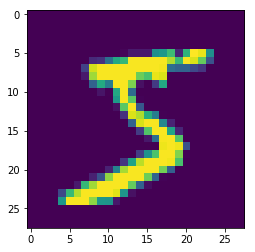

In [10]:
plt.imshow(train_dataset.train_data[0])
plt.show()

To load the model:

In [26]:
model = MNISTConvNet()
model.load_state_dict(torch.load(os.path.join(MODEL_PATH,'conv_net_1(conv)_2_model.ckpt')))

## Training a Good Convolutional Neural Network 

The ConvNet I chose has the following layers:
   * Layer 1 (Convolutional): 32 5x5 convolutional filters --> ReLU nonlinearity --> 2x2 Maxpool
   * Dropout 
   * Layer 2 (Linear): 14x14x32 --> 1000 Fully Connected layer
   * Layer 3 (Output): 1000 --> 10 Fully Connected Layer 
   * SoftMax included in nn.CrossEntropyLoss()

In [71]:
class MNISTConvNet(nn.Module):
    def __init__(self):
        super(MNISTConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
#       self.layer2 = nn.Sequential(
#           nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
#           nn.ReLU(),
#           nn.MaxPool2d(kernel_size=2, stride=2)
#           )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(14 * 14 * 32, 1000)
        self.fc2 = nn.Linear(1000, 10)
    
    def forward(self, x):
        out = self.layer1(x)
#        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 

In [72]:
model = MNISTConvNet()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [76]:
# Training the model
total_step = len(train_loader)
loss_list = []
acc_list = []

for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        # Run forward pass 
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        # Now backpropogate and apply Adam
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted==labels).sum().item()
        acc_list.append(correct / total)
        
        if (i+1) % 100 == 0:
             print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, EPOCHS, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/8], Step [100/600], Loss: 0.2443, Accuracy: 89.00%
Epoch [1/8], Step [200/600], Loss: 0.2580, Accuracy: 92.00%
Epoch [1/8], Step [300/600], Loss: 0.2750, Accuracy: 91.00%
Epoch [1/8], Step [400/600], Loss: 0.2282, Accuracy: 94.00%
Epoch [1/8], Step [500/600], Loss: 0.2843, Accuracy: 93.00%
Epoch [1/8], Step [600/600], Loss: 0.2317, Accuracy: 94.00%
Epoch [2/8], Step [100/600], Loss: 0.0868, Accuracy: 97.00%
Epoch [2/8], Step [200/600], Loss: 0.0966, Accuracy: 96.00%
Epoch [2/8], Step [300/600], Loss: 0.0300, Accuracy: 99.00%
Epoch [2/8], Step [400/600], Loss: 0.0601, Accuracy: 97.00%
Epoch [2/8], Step [500/600], Loss: 0.2003, Accuracy: 96.00%
Epoch [2/8], Step [600/600], Loss: 0.0292, Accuracy: 100.00%
Epoch [3/8], Step [100/600], Loss: 0.1290, Accuracy: 97.00%
Epoch [3/8], Step [200/600], Loss: 0.1706, Accuracy: 96.00%
Epoch [3/8], Step [300/600], Loss: 0.0772, Accuracy: 95.00%
Epoch [3/8], Step [400/600], Loss: 0.0505, Accuracy: 98.00%
Epoch [3/8], Step [500/600], Loss: 0.06

## Testing the accuracy

In [81]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted==labels).sum().item()
        total += labels.size(0)
    
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    
# Save the model and plot
torch.save(model.state_dict(), os.path.join(MODEL_PATH, 'mnist_conv1_fc2_model_new.ckpt'))

Test Accuracy of the model on the 10000 test images: 98.35000000000001 %


Now we find the variance of the output of our model

In [30]:
model.eval()

results = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        results.append(predicted)
    
results = torch.cat(results) 
variance = (results.float().std()/9)**2
print(variance)

tensor(0.1040)


In [31]:
# Compare to the pre-sample variance
(test_dataset.test_labels.float().std()/9)**2

tensor(0.1035)

### Plot accuracy and loss

In [75]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, export_png
from bokeh.models import LinearAxis, Range1d
import numpy as np

output_notebook() # for printing in jupyter

p = figure(y_axis_label='Loss', width=850, y_range=(0,1), title='PyTorch ConvNet Results')
p.extra_y_ranges = {'Accuracy': Range1d(start=0,end=100)}
p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
p.line(np.arange(len(loss_list)), loss_list)
p.line(np.arange(len(acc_list)), acc_list, color='red')
export_png(p, filename='ConvNetAccLoss.png')

Loading BokehJS ...

'/Users/tylerzhu/Desktop/tyleryzhu/pallas-starter-project/ConvNetAccLoss.png'

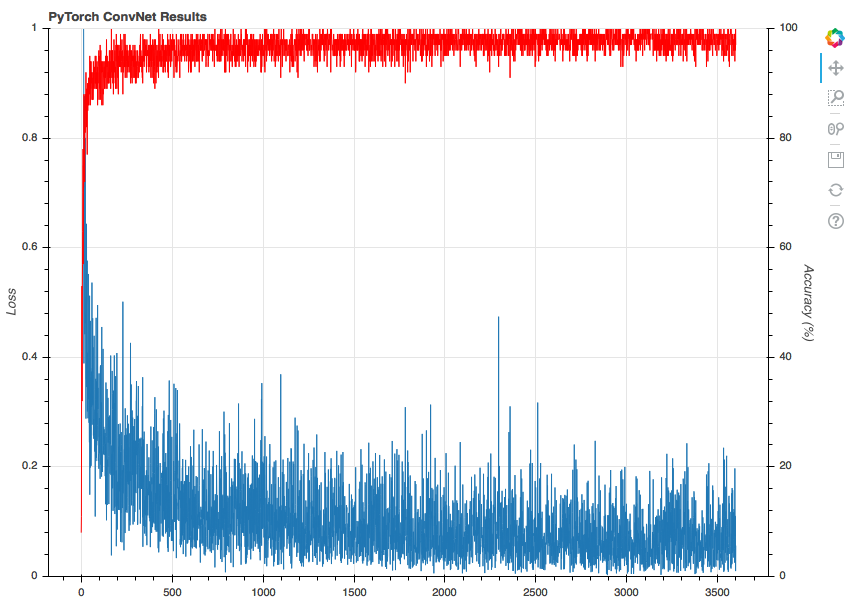

In [81]:
from IPython.display import Image
Image('./ConvNetAccLoss.png')

## Creating samples with noise

TODO: Multithread the functions here so it runs faster

In [ ]:
def addNoise(inp, sigma, clamp = True): 
    ''' Adds Gaussian noise N(0, sigma) to a ndarray or tensor inp.
        Clamps values to [0, 255]
        Returns a FloatTensor with noise added.'''
    if type(inp) != torch.Tensor:
        try:
            inp =  torch.Tensor(inp)
        except:
            print("Error: Input of type {} couldn't be converted to PyTorch tensor!".format(type(inp)))
            raise
    inp = inp.type(torch.FloatTensor)
    shape = inp.shape 
    noise = torch.tensor(np.random.normal(0, sigma, size = shape)).type(torch.FloatTensor)
    return torch.clamp(noise+inp, 0, 255) if clamp else noise+inp #to clamp or not to clamp? 

In [18]:
trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.1307,), (0.3081,))])
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans, download=False)
test_loader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)

Here I'm just plotting the images to see what kind of noise I'm getting. I also clamped the values to the range [0,255] for more consistent performance. 

In [49]:
t = test_dataset.test_data[0]

In [20]:
type(t) == torch.Tensor

True

In [55]:
u = addNoise(t, 10)
u

tensor([[ 13.,  14.,  29.,  20.,  21.,  29.,  22.,  24.,  23.,  47.,  13.,  21.,
           9.,  47.,  27.,  21.,  28.,  16.,  35.,  29.,  20.,  10.,  25.,  22.,
          24.,  21.,  42.,  25.],
        [ 20.,  27.,  29.,  39.,  34.,  26.,  15.,  32.,  25.,  20.,  28.,  15.,
          29.,  36.,  30.,  40.,  21.,  23.,  30.,  27.,  11.,  17.,  10.,  19.,
          20.,  31.,  19.,  32.],
        [ 16.,  19.,  30.,  39.,  17.,   9.,  20.,  19.,  13.,  28.,  36.,   8.,
          21.,  33.,  47.,  19.,  33.,  27.,  29.,  23.,  35.,  31.,  34.,  10.,
          24.,  24.,  39.,  43.],
        [ 20.,  25.,  22.,   9.,  25.,  38.,  26.,  30.,  31.,  25.,  12.,  15.,
          44.,  23.,  22.,  29.,  28.,  11.,  28.,  33.,  34.,   9.,  19.,  22.,
          14.,  26.,  19.,  39.],
        [ 31.,  32.,  26.,  15.,  20.,  14.,  22.,  31.,  31.,  17.,  12.,  14.,
          17.,  21.,  34.,  30.,  23.,  20.,  31.,   6.,  17.,  38.,  35.,  28.,
          22.,  23.,  29.,  13.],
        [ 12.,  13.,

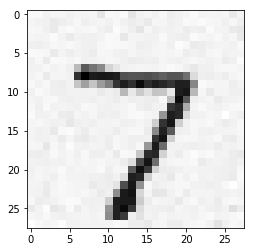

In [56]:
#plt.imshow(t, cmap='Greys')
plt.imshow(u, cmap='Greys')

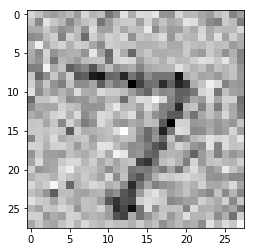

In [71]:
n = addNoise(t,80, False)
plt.imshow(n.type(torch.IntTensor), cmap='Greys')

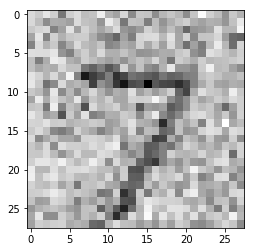

In [73]:
n = addNoise(t,80, True)
plt.imshow(n.type(torch.IntTensor), cmap='Greys')

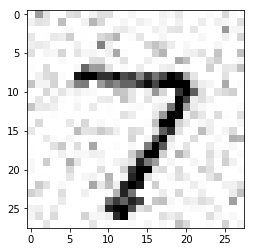

In [68]:
plt.imshow(torch.clamp(n.type(torch.IntTensor), 0, 255), cmap='Greys')

## Measuring variance 

In [ ]:
def varModel(model, loader):
    ''' Returns the variance of model over samples as a PyTorch tensor.
    
        Inputs:
        model: a PyTorch Neural Network.
        samples: a PyTorch Data Loader of the samples to test (usually test_loader)'''
    
    model.eval()
    results = []
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            results.append(predicted)

    results = torch.cat(results).float() 
    std = results.std()/(results.max()-results.min())
    return std**2

In [33]:
varModel(model, test_loader).item()

0.1039806380867958

In [ ]:
def varianceTest(model, sigmas, dataset, epochs = 5):
    ''' Finds the variance of model over X+e, where e = N(0, sigma) is Gaussian noise. 
        Each hyperparameter is run over epochs iterations. 
        
        Dataset is either 'mnist' or 'cifar10'
    
        Returns the average and s.d. of var(model(X+e)) where e = N(0, sigma) for each 
        sigma in sigmas over epochs number of iterations.'''
    if dataset not in ['mnist', 'cifar10']:
        print('Dataset {} not found!'.format(dataset))
        return 
    if dataset == 'mnist':
        trans = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])
    elif dataset == 'cifar10':
        trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])
    outputVariance = []
    outputVarianceSTD = []
    for sigma in sigmas:
        print("Computing variance of f(Y) where noise has sigma =", sigma)
        tot = []
        for epoch in range(epochs): 
            print("Epoch {} of {}".format(epoch+1, epochs))
            if dataset == 'mnist':
                noisy_test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, \
                                                            transform=trans,download=False)
            elif dataset == 'cifar10':
                noisy_test_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, \
                                                            transform=trans,download=False)
            for i in range(len(noisy_test_dataset.test_data)):
                noisy_test_dataset.test_data[i] = addNoise(noisy_test_dataset.test_data[i], sigma)
            test_loader = DataLoader(dataset = noisy_test_dataset, batch_size=BATCH_SIZE, shuffle = False)
            tot.append(varModel(model, test_loader).item())
        tot = np.array(tot)
        outputVariance.append(tot.mean())
        outputVarianceSTD.append(tot.std())
        print("Variance with noise std {} is {}. STD is {}".format(sigma, outputVariance[-1], outputVarianceSTD[-1]))
    return outputVariance, outputVarianceSTD

In [78]:
sigs = np.linspace(0, 80, 9) 
print(sigs)

[ 0. 10. 20. 30. 40. 50. 60. 70. 80.]


Computing variance of f(Y) where noise has sigma = 0.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 0.0 is 0.1033945083618164. STD is 0.0
Computing variance of f(Y) where noise has sigma = 10.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 10.0 is 0.10742429047822952. STD is 0.00016049240308563378
Computing variance of f(Y) where noise has sigma = 20.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 20.0 is 0.11583402454853058. STD is 0.00016775111079568174
Computing variance of f(Y) where noise has sigma = 30.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 30.0 is 0.12395515888929368. STD is 0.00027282263806567027
Computing variance of f(Y) where noise has sigma = 40.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 40.0 is 0.12983012795448304. STD is 0.0003767252093573911
Com

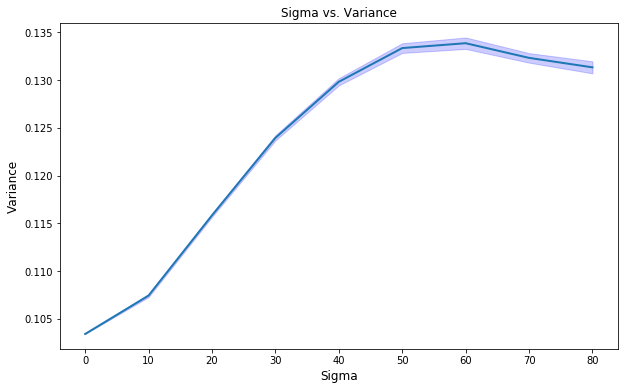

In [80]:
res, resSTD = varianceTest(model, sigs, epochs = 5, dataset='mnist')
display(sigs, res, resSTD)

In [46]:
res, resSTD = varianceTest(modelMNIST, sigs, epochs = 5, dataset='mnist') #old one

Computing variance of f(Y) where noise has sigma = 0.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 0.0 is 0.10386093705892563. STD is 0.0
Computing variance of f(Y) where noise has sigma = 10.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 10.0 is 0.10689981430768966. STD is 6.70481958612121e-05
Computing variance of f(Y) where noise has sigma = 20.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 20.0 is 0.11472281813621521. STD is 0.00015917068297755245
Computing variance of f(Y) where noise has sigma = 30.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 30.0 is 0.11004408597946166. STD is 0.0006546056126123039
Computing variance of f(Y) where noise has sigma = 40.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 40.0 is 0.08651356399059296. STD is 0.0005009478490754483
Compu

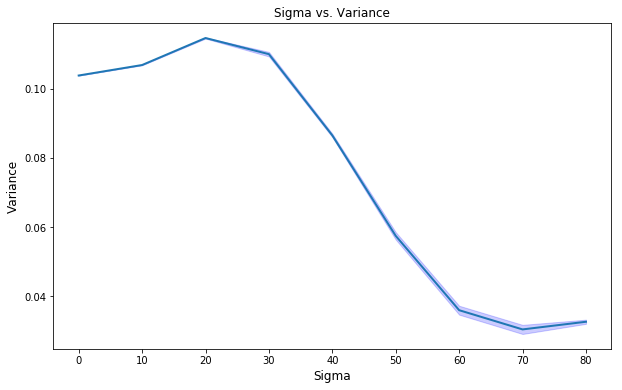

In [47]:
display(sigs, res, resSTD)

In [223]:
res, resSTD = varianceTest(model, sigs, epochs = 5)

Computing variance of f(Y) where noise has sigma = 0.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 0.0 is 0.10386093705892563. STD is 0.0
Computing variance of f(Y) where noise has sigma = 10.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 10.0 is 0.10394573360681533. STD is 3.667211929617332e-05
Computing variance of f(Y) where noise has sigma = 20.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 20.0 is 0.1038870245218277. STD is 3.676458343785538e-05
Computing variance of f(Y) where noise has sigma = 30.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 30.0 is 0.10375198870897293. STD is 8.672893644067376e-05
Computing variance of f(Y) where noise has sigma = 40.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 40.0 is 0.10337993949651718. STD is 0.00018889814023540202
Compu

In [72]:
def display(sigmas, results, resultsSTD):
    results = np.array(results)
    resultsSTD = np.array(resultsSTD)
    plt.figure(figsize=(10,6))
    plt.fill_between(sigmas, list(results-resultsSTD), list(results+resultsSTD), color='b',alpha=.2)
    plt.plot(sigmas, results, lw=2)
    plt.xlabel('Sigma', fontsize=12)
    plt.ylabel('Variance', fontsize=12)
    plt.title('Sigma vs. Variance')
    plt.show()

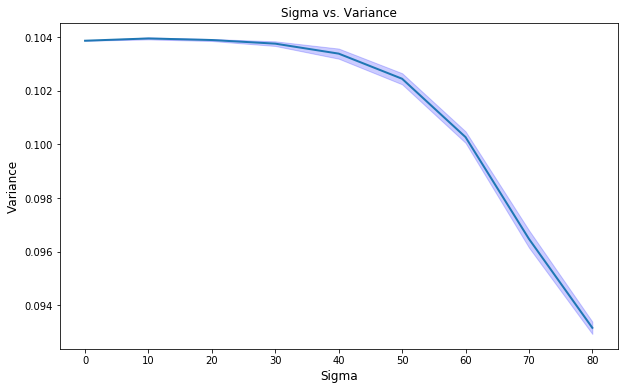

In [239]:
display(sigs, res, resSTD)

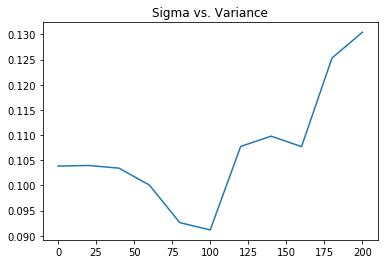

In [168]:
display(sigs, result)

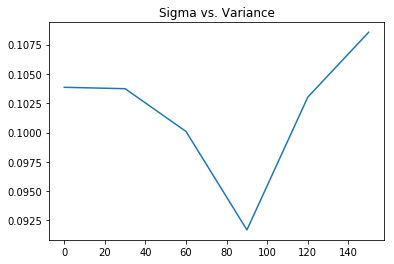

In [175]:
display(sigs, result)

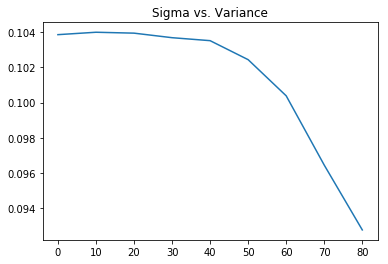

In [188]:
display(sigs, result)

# Objective 2

Do the same as above but with the CNN using a shiftresnet layer

Here's me toying around with getting a single kernel to work on a 5x5 image with one channel

In [101]:
conv_filter = torch.zeros(3,3)
conv_filter[0][1] = 1 
x = torch.randn(1, 1, 5, 5) # batch of 1 5x5 image w/ 1 channel
conv_filter = conv_filter.unsqueeze(0).unsqueeze(0)
conv_filter.size()

torch.Size([1, 1, 3, 3])

In [96]:
output = F.conv2d(x, conv_filter, padding = 1)

In [98]:
x

tensor([[[[-0.1891,  0.2041, -0.7315,  0.4882, -0.9014],
          [-0.1818, -0.3181, -1.2614, -2.3275, -0.0823],
          [ 2.5264,  0.3269,  0.2228,  0.5010, -1.2667],
          [-1.0320, -0.3863, -1.2166, -0.4680,  1.0364],
          [ 0.1225, -0.5095,  0.6704,  0.1047,  0.9392]]]])

In [97]:
output

tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [-0.1891,  0.2041, -0.7315,  0.4882, -0.9014],
          [-0.1818, -0.3181, -1.2614, -2.3275, -0.0823],
          [ 2.5264,  0.3269,  0.2228,  0.5010, -1.2667],
          [-1.0320, -0.3863, -1.2166, -0.4680,  1.0364]]]])

In [102]:
conv_filter = torch.zeros(9, 1, 3, 3)

In [107]:
np.random.seed(42)
ind = np.arange(9)
np.random.shuffle(ind)
print(ind)
for i in range(len(conv_filter)):
    conv_filter[i][0][ind[i]//3][ind[i]%3] = 1
print(conv_filter)

[7 1 5 0 8 2 4 3 6]
tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 1., 0.]]],


        [[[0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 1.],
          [0., 0., 0.]]],


        [[[1., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 1.]]],


        [[[0., 0., 1.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [1., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [1., 0., 0.]]]])


In [111]:
x = torch.randn(1, 1, 5, 5)
print(x)

tensor([[[[ 1.4164, -0.3392,  0.6516, -1.6113, -1.2294],
          [ 0.3423,  0.2105,  0.0591, -0.3411,  1.3928],
          [-0.1062,  0.3385,  0.3277, -0.3282, -0.2298],
          [ 1.1247,  1.4374, -0.8443,  1.1783,  0.1931],
          [-0.9160, -0.3821, -0.1675, -0.2039,  0.1200]]]])


In [113]:
output = F.conv2d(x, conv_filter, padding = 1)
print(output)
print(output.size())

tensor([[[[ 0.3423,  0.2105,  0.0591, -0.3411,  1.3928],
          [-0.1062,  0.3385,  0.3277, -0.3282, -0.2298],
          [ 1.1247,  1.4374, -0.8443,  1.1783,  0.1931],
          [-0.9160, -0.3821, -0.1675, -0.2039,  0.1200],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 1.4164, -0.3392,  0.6516, -1.6113, -1.2294],
          [ 0.3423,  0.2105,  0.0591, -0.3411,  1.3928],
          [-0.1062,  0.3385,  0.3277, -0.3282, -0.2298],
          [ 1.1247,  1.4374, -0.8443,  1.1783,  0.1931]],

         [[-0.3392,  0.6516, -1.6113, -1.2294,  0.0000],
          [ 0.2105,  0.0591, -0.3411,  1.3928,  0.0000],
          [ 0.3385,  0.3277, -0.3282, -0.2298,  0.0000],
          [ 1.4374, -0.8443,  1.1783,  0.1931,  0.0000],
          [-0.3821, -0.1675, -0.2039,  0.1200,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  1.4164, -0.3392,  0.6516, -1.6113],
          [ 0.0000,  0.34

In [84]:
output

tensor([[[[ 0.4333,  3.5575],
          [-0.1207, -1.0694],
          [ 1.6642,  2.2067],
          [-0.0162,  0.4548],
          [-0.8075,  1.2660]]]])

## Creating the ShiftNet Module

In [80]:
# Hyperparameters
EPOCHS = 20 
CLASSES = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.001

In [8]:
# a transform to apply to data (convert to Tensor, then normalize w/ MNIST's mean & sd)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=trans)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

train_loader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)

In [81]:
class ShiftConvNet(nn.Module):
    def __init__(self):
        super(ShiftConvNet, self).__init__()
        self.shift_size = 5
        
        self.BN_first = nn.BatchNorm2d(1)
        self.conv_1x1_first = nn.Conv2d(1, 20, kernel_size = 1, stride = 1, padding = 0, bias = False)
        self.shift_kernel = self._make_shift(self.shift_size, 1)
        self.BN = nn.BatchNorm2d(self.shift_size**2)
        self.conv_1x1 = nn.Conv2d(self.shift_size**2, 40, kernel_size = 1, stride = 1, padding = 0, bias = False)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #Pool is so important! increased acc by a lot
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(40*14*14, 1000)
        self.fc2 = nn.Linear(1000, 10)
    
    def forward(self, x):
#        out = F.relu(self.BN_first(x))
        out = self.conv_1x1_first(x)
        out = F.conv2d(x, self.shift_kernel, padding = self.shift_size//2) #shift 
        out = F.relu(self.BN(out))
        out = self.conv_1x1(out)
        out = self.pool(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 
   
    def _make_shift(self, img_size, num_channels = 1):
        conv = torch.zeros(img_size**2, num_channels, img_size, img_size)
        
        # Creates shifts in the 9 kernels
        for c in range(num_channels):
            ind = np.arange(img_size**2)
            np.random.shuffle(ind)
            for i in range(len(conv)): 
                conv[i][c][ind[i]//img_size][ind[i]%img_size] = 1
        return conv

In [82]:
model = ShiftConvNet()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [83]:
# Training the model
total_step = len(train_loader)
loss_list = []
acc_list = []

for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        # Run forward pass 
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        # Now backpropogate and apply Adam
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted==labels).sum().item()
        acc_list.append(correct / total)
        
        if (i+1) % 100 == 0:
             print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, EPOCHS, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/20], Step [100/600], Loss: 0.2503, Accuracy: 93.00%
Epoch [1/20], Step [200/600], Loss: 0.1056, Accuracy: 96.00%
Epoch [1/20], Step [300/600], Loss: 0.3787, Accuracy: 92.00%
Epoch [1/20], Step [400/600], Loss: 0.1855, Accuracy: 96.00%
Epoch [1/20], Step [500/600], Loss: 0.0879, Accuracy: 96.00%
Epoch [1/20], Step [600/600], Loss: 0.2084, Accuracy: 94.00%
Epoch [2/20], Step [100/600], Loss: 0.0966, Accuracy: 97.00%
Epoch [2/20], Step [200/600], Loss: 0.1252, Accuracy: 95.00%
Epoch [2/20], Step [300/600], Loss: 0.1741, Accuracy: 96.00%
Epoch [2/20], Step [400/600], Loss: 0.1217, Accuracy: 95.00%
Epoch [2/20], Step [500/600], Loss: 0.1753, Accuracy: 94.00%
Epoch [2/20], Step [600/600], Loss: 0.1910, Accuracy: 94.00%
Epoch [3/20], Step [100/600], Loss: 0.1310, Accuracy: 96.00%
Epoch [3/20], Step [200/600], Loss: 0.0355, Accuracy: 99.00%
Epoch [3/20], Step [300/600], Loss: 0.2002, Accuracy: 93.00%
Epoch [3/20], Step [400/600], Loss: 0.1796, Accuracy: 96.00%
Epoch [3/20], Step [500/

In [84]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted==labels).sum().item()
        total += labels.size(0)
    
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 97.89 %


Current Accuracies:
    - 98.19% on 15 epochs, 1x1 -> 3x3 shift -> BN, ReLU -> 1x1 -> MaxPool for shift module 
    - 97.90% on 12 epochs, 1x1 -> 3x3 shift -> BN, ReLU -> 1x1 -> MaxPool for shift module
    - 97.89% on 20 epochs, 1x1 -> 5x5 shift -> BN, ReLU -> 1x1 -> MaxPool for shift module
    - 97.63% on 10 epochs, 1x1 -> 5x5 shift -> BN, ReLU -> 1x1 -> MaxPool for shift module
    - 97.63% on 20 epochs,        3x3 shift -> BN, ReLU -> 1x1 -> MaxPool for shift module 
    - 97.38% on 10 epochs, 1x1 -> 3x3 shift -> BN, ReLU -> 1x1 -> MaxPool for shift module
    - 97.32% on 12 epochs, BN, ReLU -> 1x1 -> 3x3 shift -> BN, ReLU -> 1x1 -> MaxPool for shift module

Things that didn't work: 
    - Changing MaxPool -> AvgPool
    - Using a stride 2 1x1 convolution at the end 
    - Concatenating an AvgPool of the input with the finished tensor

In [89]:
# Save the model and plot
torch.save(model.state_dict(), MODEL_PATH + 'mnist_shift1_fc2_bn_model.ckpt')

In [90]:
#Load Model
shiftModelMNIST = ShiftConvNet()
shiftModelMNIST.load_state_dict(torch.load(MODEL_PATH + 'mnist_shift1_fc2_bn_model.ckpt'))

In [273]:
# To evaluate a model's baseline accuracy
def accModel(model, loader): 
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted==labels).sum().item()
            total += labels.size(0)
        return (correct / total) * 100

In [91]:
accModel(model, test_loader)

97.89

In [92]:
accModel(shiftModelMNIST, test_loader)

41.75

In [256]:
#Load Model
shiftModelMNIST = ShiftConvNet()
shiftModelMNIST.load_state_dict(torch.load(MODEL_PATH + 'mnist_shift1_fc2_model.ckpt'))

In [275]:
#Load Model
model = ShiftConvNet()
model.load_state_dict(torch.load(MODEL_PATH + 'mnist_shift1_fc2_model.ckpt'))

# Test with CIFAR-10 

## Train CNN on CIFAR-10

First we train a model on CIFAR-10

In [51]:
# Hyperparameters
EPOCHS = 4
CLASSES = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.001

In [43]:
# a transform to apply to data (convert to Tensor, then normalize w/ CIFAR-10's mean & sd on RGB channels)
trans = transforms.Compose([#transforms.ToPILImage(), 
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])

# CIFAR-10 
train_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=False, transform=trans)
test_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, transform=trans)

In [44]:
train_loader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)

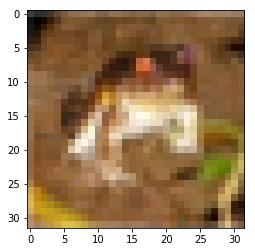

In [45]:
plt.imshow(train_loader.dataset.train_data[0])

In [46]:
train_loader.dataset.train_data[0].shape

(32, 32, 3)

In [ ]:
class CIFARConvNet(nn.Module):
    def __init__(self):
        super(CIFARConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
#       self.layer2 = nn.Sequential(
#           nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
#           nn.ReLU(),
#           nn.MaxPool2d(kernel_size=2, stride=2)
#           )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(16 * 16 * 32, 2000)
        self.fc2 = nn.Linear(2000, 10)
    
    def forward(self, x):
        out = self.layer1(x)
#        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 

In [48]:
model = CIFARConvNet()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [52]:
# Training the model
total_step = len(train_loader)
loss_list = []
acc_list = []

for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        # Run forward pass 
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        # Now backpropogate and apply Adam
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted==labels).sum().item()
        acc_list.append(correct / total)
        
        if (i+1) % 100 == 0:
             print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, EPOCHS, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/6], Step [100/500], Loss: 1.1088, Accuracy: 56.00%
Epoch [1/6], Step [200/500], Loss: 1.2240, Accuracy: 53.00%
Epoch [1/6], Step [300/500], Loss: 1.1352, Accuracy: 63.00%
Epoch [1/6], Step [400/500], Loss: 1.2080, Accuracy: 55.00%
Epoch [1/6], Step [500/500], Loss: 1.2460, Accuracy: 57.00%
Epoch [2/6], Step [100/500], Loss: 0.9806, Accuracy: 66.00%
Epoch [2/6], Step [200/500], Loss: 1.0705, Accuracy: 63.00%
Epoch [2/6], Step [300/500], Loss: 1.0897, Accuracy: 64.00%
Epoch [2/6], Step [400/500], Loss: 1.2209, Accuracy: 53.00%
Epoch [2/6], Step [500/500], Loss: 1.2357, Accuracy: 61.00%
Epoch [3/6], Step [100/500], Loss: 1.3621, Accuracy: 56.00%
Epoch [3/6], Step [200/500], Loss: 1.0152, Accuracy: 68.00%
Epoch [3/6], Step [300/500], Loss: 1.2386, Accuracy: 60.00%
Epoch [3/6], Step [400/500], Loss: 1.0950, Accuracy: 69.00%
Epoch [3/6], Step [500/500], Loss: 1.0712, Accuracy: 66.00%
Epoch [4/6], Step [100/500], Loss: 1.0963, Accuracy: 62.00%
Epoch [4/6], Step [200/500], Loss: 0.938

In [62]:
def evaluateAccuracy(model, test_loader): 
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted==labels).sum().item()
            total += labels.size(0)

        print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
evaluateAccuracy(model, test_loader) 
# Save the model and plot
torch.save(model.state_dict(), os.path.join(MODEL_PATH,'cifar_conv1_fc2_model.ckpt'))

Test Accuracy of the model on the 10000 test images: 63.13999999999999 %


## Measure output variance 

In [ ]:
modelCIFAR = CIFARConvNet()
modelCIFAR.load_state_dict(torch.load(MODEL_PATH + 'cifar_conv1_fc2_model.ckpt'))

In [65]:
varModel(modelCIFAR, test_loader)

tensor(0.1098)

In [66]:
sigs = np.linspace(0, 60, 7) 
print(sigs)

[ 0. 10. 20. 30. 40. 50. 60.]


Computing variance of f(Y) where noise has sigma = 0.0
Epoch 1 of 6
Epoch 2 of 6
Epoch 3 of 6
Epoch 4 of 6
Epoch 5 of 6
Epoch 6 of 6
Variance with noise std 0.0 is 0.11344992369413376. STD is 0.0
Computing variance of f(Y) where noise has sigma = 10.0
Epoch 1 of 6
Epoch 2 of 6
Epoch 3 of 6
Epoch 4 of 6
Epoch 5 of 6
Epoch 6 of 6
Variance with noise std 10.0 is 0.11183217540383339. STD is 0.00020617874687709224
Computing variance of f(Y) where noise has sigma = 20.0
Epoch 1 of 6
Epoch 2 of 6
Epoch 3 of 6
Epoch 4 of 6
Epoch 5 of 6
Epoch 6 of 6
Variance with noise std 20.0 is 0.11728457485636075. STD is 0.0002913063684056205
Computing variance of f(Y) where noise has sigma = 30.0
Epoch 1 of 6
Epoch 2 of 6
Epoch 3 of 6
Epoch 4 of 6
Epoch 5 of 6
Epoch 6 of 6
Variance with noise std 30.0 is 0.12560017655293146. STD is 0.00022716394190480652
Computing variance of f(Y) where noise has sigma = 40.0
Epoch 1 of 6
Epoch 2 of 6
Epoch 3 of 6
Epoch 4 of 6
Epoch 5 of 6
Epoch 6 of 6
Variance with noise 

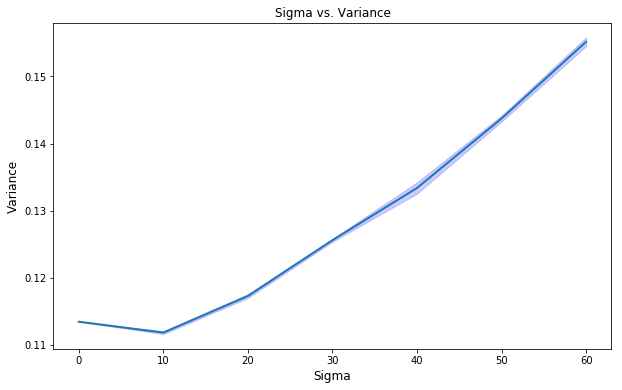

In [67]:
res, resSTD = varianceTest(modelCIFAR, sigs, dataset = 'cifar10', epochs = 6)
display(sigs, res, resSTD)

In [68]:
sigs2 = np.linspace(0, 120, 5)
print(sigs2)
res, resSTD = varianceTest(modelCIFAR, sigs2, dataset = 'cifar10', epochs = 3)

[  0.  30.  60.  90. 120.]
Computing variance of f(Y) where noise has sigma = 0.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 0.0 is 0.11344992369413376. STD is 0.0
Computing variance of f(Y) where noise has sigma = 30.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 30.0 is 0.12504267195860544. STD is 0.000556828156830979
Computing variance of f(Y) where noise has sigma = 60.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 60.0 is 0.15508961180845895. STD is 0.0006545912662299702
Computing variance of f(Y) where noise has sigma = 90.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 90.0 is 0.17551058530807495. STD is 0.0003534199789224031
Computing variance of f(Y) where noise has sigma = 120.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 120.0 is 0.18253387014071146. STD is 0.0004412817852173159


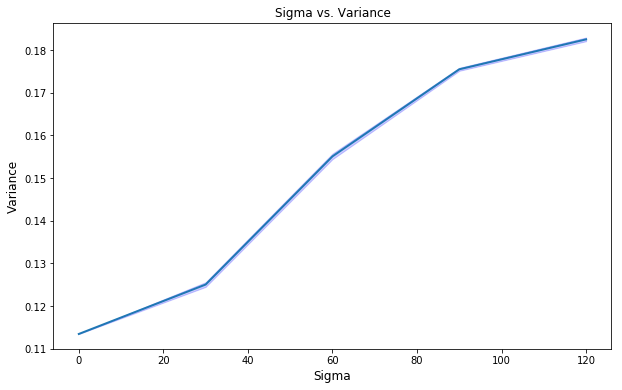

In [69]:
display(sigs2, res, resSTD)

In [21]:
sigs2 = np.linspace(0, 120, 5)
print(sigs2)
res, resSTD = varianceTest(modelCIFAR, sigs2, dataset = 'cifar10', epochs = 3)

[  0.  30.  60.  90. 120.]
Computing variance of f(Y) where noise has sigma = 0.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 0.0 is 0.09873133152723312. STD is 0.0
Computing variance of f(Y) where noise has sigma = 30.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 30.0 is 0.11027581989765167. STD is 0.0005179726913842064
Computing variance of f(Y) where noise has sigma = 60.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 60.0 is 0.1285632848739624. STD is 0.0017940441045435295
Computing variance of f(Y) where noise has sigma = 90.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 90.0 is 0.08690366894006729. STD is 0.010996116910540593
Computing variance of f(Y) where noise has sigma = 120.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 120.0 is 0.06005295366048813. STD is 0.0013251503418518359


(5,) (5,) (5,)


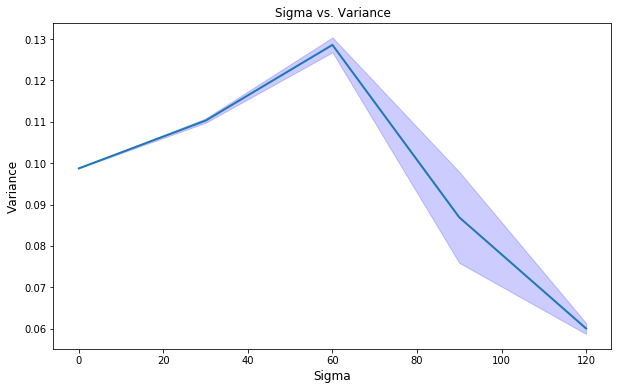

In [22]:
print(sigs2.shape, np.array(res).shape, np.array(resSTD).shape)
display(sigs2, res, resSTD)

# Comparing accuracy on noisy inputs

In [17]:
# To evaluate a model's baseline accuracy
def accModel(model, loader): 
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted==labels).sum().item()
            total += labels.size(0)
        return (correct / total) * 100

In [18]:
def varModel(model, loader):
    ''' Returns the variance of model over samples as a PyTorch tensor.
    
        Inputs:
        model: a PyTorch Neural Network.
        samples: a PyTorch Data Loader of the samples to test (usually test_loader)'''
    
    model.eval()
    results = []
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            results.append(predicted)

    results = torch.cat(results).float() 
    std = results.std()/(results.max()-results.min())
    return std**2

In [19]:
def addNoise(inp, sigma, clamp = True): 
    ''' Adds Gaussian noise N(0, sigma) to a ndarray or tensor inp.
        Clamps values to [0, 255]
        Returns a FloatTensor with noise added.'''
    if type(inp) != torch.Tensor:
        try:
            inp =  torch.Tensor(inp)
        except:
            print("Error: Input of type {} couldn't be converted to PyTorch tensor!".format(type(inp)))
            raise
    inp = inp.type(torch.FloatTensor)
    shape = inp.shape 
    noise = torch.tensor(np.random.normal(0, sigma, size = shape)).type(torch.FloatTensor)
    result = noise+inp
    lo, hi = torch.min(result), torch.max(result)
    result = (result-lo)*255//(hi-lo)
    return result if clamp else noise+inp
    return torch.clamp(noise+inp, 0, 255) if clamp else noise+inp #to clamp or not to clamp? 

In [20]:
# Main function
def varianceTest(model, sigmas, dataset, epochs = 5):
    ''' Finds the variance of model over X+e, where e = N(0, sigma) is Gaussian noise. 
        Each hyperparameter is run over epochs iterations. 
        
        Dataset is either 'mnist' or 'cifar10'
    
        Returns the average and s.d. of var(model(X+e)) where e = N(0, sigma) for each 
        sigma in sigmas over epochs number of iterations.'''
    if dataset not in ['mnist', 'cifar10']:
        print('Dataset {} not found!'.format(dataset))
        return 
    if dataset == 'mnist':
        trans = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])
    elif dataset == 'cifar10':
        trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])
    outputVariance = []
    outputVarianceSTD = []
    for sigma in sigmas:
        print("Computing variance of f(Y) where noise has sigma =", sigma)
        tot = []
        for epoch in range(epochs): 
            print("Epoch {} of {}".format(epoch+1, epochs))
            if dataset == 'mnist':
                noisy_test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, \
                                                            transform=trans,download=False)
            elif dataset == 'cifar10':
                noisy_test_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, \
                                                            transform=trans,download=False)
            for i in range(len(noisy_test_dataset.test_data)):
                noisy_test_dataset.test_data[i] = addNoise(noisy_test_dataset.test_data[i], sigma)
            test_loader = DataLoader(dataset = noisy_test_dataset, batch_size=BATCH_SIZE, shuffle = False)
            tot.append(varModel(model, test_loader).item())
        tot = np.array(tot)
        outputVariance.append(tot.mean())
        outputVarianceSTD.append(tot.std())
        print("Variance with noise std {} is {}. STD is {}".format(sigma, outputVariance[-1], outputVarianceSTD[-1]))
    return outputVariance, outputVarianceSTD

In [21]:
# Main function
def accuracyTest(CNN, ShiftNet, sigmas, dataset, epochs = 5):
    ''' Computes the accuracy of spatial vs. shift model over X+e, 
        where e = N(0, sigma) is Gaussian noise. 
        Each hyperparameter is run over epochs iterations. 
        
        Dataset is either 'mnist' or 'cifar10'
    
        Returns the average and s.d. of model(X+e) where e = N(0, sigma) for each 
        sigma in sigmas over epochs number of iterations.'''
    if dataset not in ['mnist', 'cifar10']:
        print('Dataset {} not found!'.format(dataset))
        return 
    if dataset == 'mnist':
        trans = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])
    elif dataset == 'cifar10':
        trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])
    output = []
    outputSTD = []
    shift_output = []
    shift_outputSTD = []
    for sigma in sigmas:
        print("Computing accuracy of f(Y) where noise has sigma =", sigma)
        tot = []
        shift_tot = []
        for epoch in range(epochs): 
            print("Epoch {} of {}".format(epoch+1, epochs))
            if dataset == 'mnist':
                noisy_test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, \
                                                            transform=trans,download=False)
            elif dataset == 'cifar10':
                noisy_test_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, \
                                                            transform=trans,download=False)
            for i in range(len(noisy_test_dataset.test_data)):
                noisy_test_dataset.test_data[i] = addNoise(noisy_test_dataset.test_data[i], sigma)
            test_loader = DataLoader(dataset = noisy_test_dataset, batch_size=BATCH_SIZE, shuffle = False)
            tot.append(accModel(CNN, test_loader))
            shift_tot.append(accModel(ShiftNet, test_loader))
        tot = np.array(tot)
        shift_tot = np.array(shift_tot)
        output.append(tot.mean())
        outputSTD.append(tot.std())
        shift_output.append(shift_tot.mean())
        shift_outputSTD.append(shift_tot.std())
        print("Accuracy of CNN with noise std {} is {}. STD is {}".format(sigma, output[-1], outputSTD[-1]))
        print("Accuracy of ShiftNet with noise std {} is {}. STD is {}".format(sigma, shift_output[-1], shift_outputSTD[-1]))
    return output, outputSTD, shift_output, shift_outputSTD

In [23]:
def display(sigmas, results, resultsSTD):
    results = np.array(results)
    resultsSTD = np.array(resultsSTD)
    plt.figure(figsize=(10,6))
    plt.fill_between(sigmas, list(results-resultsSTD), list(results+resultsSTD), color='b',alpha=.2)
    plt.plot(sigmas, results, lw=2)
    plt.xlabel('Sigma', fontsize=12)
    plt.ylabel('Variance', fontsize=12)
    plt.title('Sigma vs. Variance')
    plt.show()

In [263]:
# For MNIST Model
modelMNIST = MNISTConvNet()
modelMNIST.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'mnist_conv1_fc2_model_new.ckpt')))

[ 0. 10. 20. 30. 40. 50. 60. 70. 80.]
Computing variance of f(Y) where noise has sigma = 0.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 0.0 is 0.10329890996217728. STD is 0.0
Computing variance of f(Y) where noise has sigma = 10.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 10.0 is 0.10257425904273987. STD is 8.100958711512167e-05
Computing variance of f(Y) where noise has sigma = 20.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 20.0 is 0.1008670801917712. STD is 6.843421355330124e-05
Computing variance of f(Y) where noise has sigma = 30.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 30.0 is 0.10021534562110901. STD is 0.00023623540691396816
Computing variance of f(Y) where noise has sigma = 40.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 40.0 is 0.10051337877909343. STD is 0.00022192906893199571
Computing variance of f(Y) where noise has sigma = 50.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
V

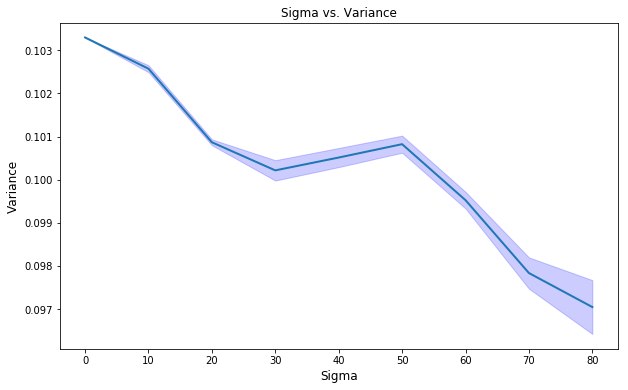

In [85]:
sigs = np.linspace(0, 80, 9) 
print(sigs)
res, resSTD = varianceTest(model, sigs, 'mnist', epochs = 3)
display(sigs, res, resSTD)

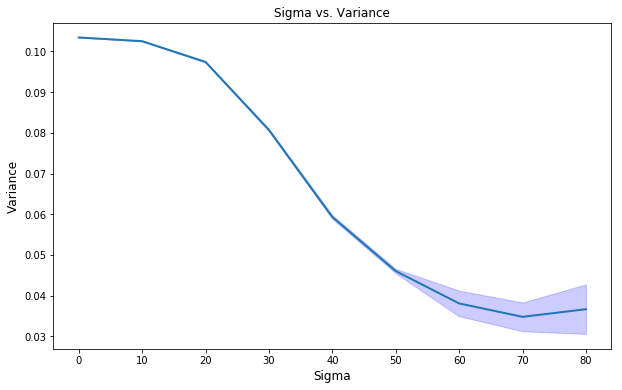

In [25]:
display(sigs, res, resSTD)

In [264]:
c_results, c_resultsSTD = varianceTest(modelMNIST, sigs, epochs = 5, dataset='mnist')

Computing variance of f(Y) where noise has sigma = 0.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 0.0 is 0.1033945083618164. STD is 0.0
Computing variance of f(Y) where noise has sigma = 10.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 10.0 is 0.10754713863134384. STD is 8.704408265409905e-05
Computing variance of f(Y) where noise has sigma = 20.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 20.0 is 0.11597123295068741. STD is 5.474857099145701e-05
Computing variance of f(Y) where noise has sigma = 30.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 30.0 is 0.12380402535200119. STD is 0.0003396426242657218
Computing variance of f(Y) where noise has sigma = 40.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 40.0 is 0.129699969291687. STD is 0.0004284521773594518
Computin

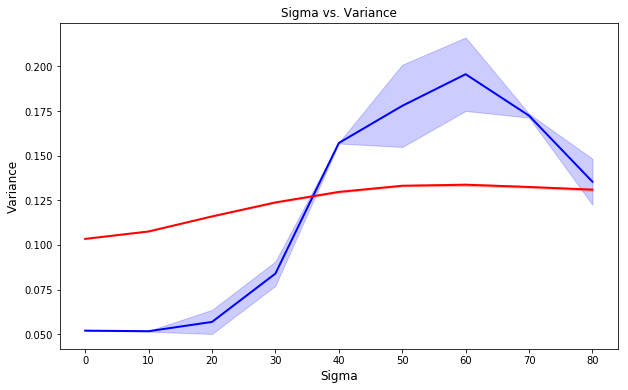

In [266]:
s_results= np.array(res)
s_resultsSTD = np.array(resSTD)
results = np.array(c_results)
resultsSTD = np.array(c_resultsSTD)
plt.figure(figsize=(10,6))
plt.fill_between(sigs, list(s_results-s_resultsSTD), list(s_results+s_resultsSTD), color='b',alpha=.2)
plt.fill_between(sigs, list(results-resultsSTD), list(results+resultsSTD), color='r',alpha=.2)
plt.plot(sigs, s_results, color = 'b', lw=2)
plt.plot(sigs, results, color = 'r', lw=2)
plt.xlabel('Sigma', fontsize=12)
plt.ylabel('Variance', fontsize=12)
plt.title('Sigma vs. Variance')
plt.show()

In [86]:
output, outputSTD, shift_output, shift_outputSTD = accuracyTest(modelMNIST, model, sigs, 'mnist')

Computing accuracy of f(Y) where noise has sigma = 0.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Accuracy of CNN with noise std 0.0 is 98.35000000000001. STD is 0.0
Accuracy of ShiftNet with noise std 0.0 is 97.89. STD is 0.0
Computing accuracy of f(Y) where noise has sigma = 10.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Accuracy of CNN with noise std 10.0 is 94.63. STD is 0.14628738838327837
Accuracy of ShiftNet with noise std 10.0 is 95.82200000000002. STD is 0.0735934779718979
Computing accuracy of f(Y) where noise has sigma = 20.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Accuracy of CNN with noise std 20.0 is 80.336. STD is 0.13850631754544843
Accuracy of ShiftNet with noise std 20.0 is 92.242. STD is 0.06794115100585031
Computing accuracy of f(Y) where noise has sigma = 30.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Accuracy of CNN with noise std 30.0 is 59.016. STD is 0.07255342858886832

In [272]:
accModel(shiftModelMNIST, test_loader)

16.16

In [87]:
def displayTwo(one, oneSTD, two, twoSTD, xlabel = 'Sigma', ylabel = 'Variance', title = 'Sigma vs. Variance'):
    out= np.array(one)
    outSTD= np.array(oneSTD)
    shiftout= np.array(two)
    shiftoutSTD= np.array(twoSTD)
    plt.figure(figsize=(10,6))
    plt.fill_between(sigs, list(out-10*outSTD), list(out+10*outSTD), color='b',alpha=.2)
    plt.fill_between(sigs, list(shiftout-10*shiftoutSTD), list(shiftout+10*shiftoutSTD), color='r',alpha=.2)
    plt.plot(sigs, out, color = 'b', lw=2, label = 'CNN')
    plt.plot(sigs, shiftout, color = 'r', lw=2, label = 'ShiftNet')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    plt.legend(loc = 'upper right')
    plt.show()

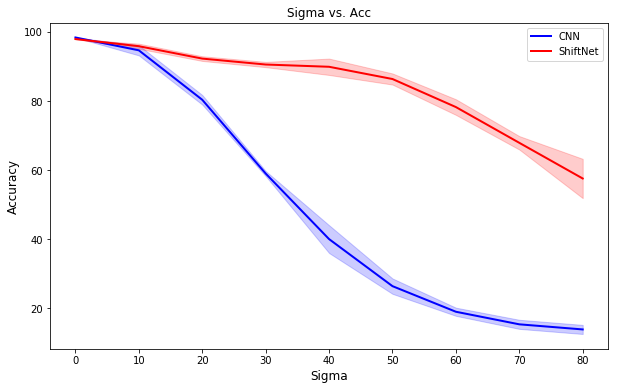

In [88]:
displayTwo(output, outputSTD, shift_output, shift_outputSTD, ylabel = 'Accuracy', title = 'Sigma vs. Acc')

In [231]:
output, outputSTD, shift_output, shift_outputSTD = ([98.35000000000001,
  94.09599999999999,
  83.702,
  73.632,
  64.574,
  56.492,
  49.251999999999995,
  42.861999999999995,
  36.922000000000004],
 [0.0,
  0.07631513611335947,
  0.20419598428960226,
  0.16424372134117818,
  0.09707728879609291,
  0.20497804760510466,
  0.27036271932350586,
  0.3296300957133624,
  0.4369622409316399],
 [13.020000000000001,
  19.201999999999998,
  20.008,
  16.788,
  13.857999999999999,
  12.672,
  12.069999999999999,
  11.951999999999998,
  11.796],
 [0.0,
  0.04399999999999981,
  0.0923904756996095,
  0.07704544113703342,
  0.020396078054370426,
  0.09744742172063871,
  0.10936178491593825,
  0.04915282290977762,
  0.08957678270623426])

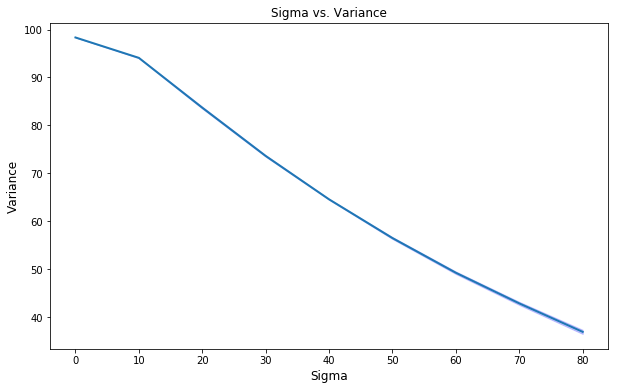

In [232]:
display(sigs, output, outputSTD)

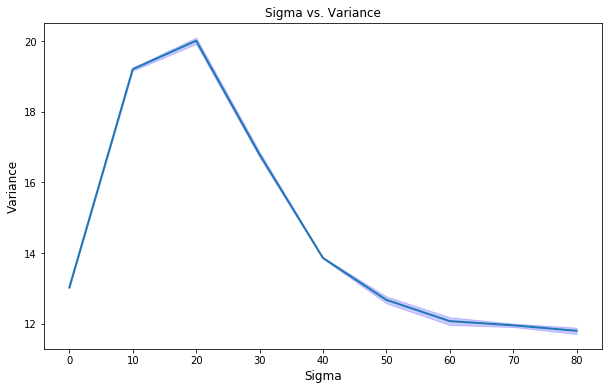

In [233]:
display(sigs, shift_output, shift_outputSTD)